In [3]:
# resnet18_training.py

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Paths
DATASET_DIR = "../data/processed"
train_dir = os.path.join(DATASET_DIR, "train")
val_dir = os.path.join(DATASET_DIR, "val")
test_dir = os.path.join(DATASET_DIR, "test")

In [6]:
# === Transforms ===
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
# Load datasets
datasets_dict = {
    'train': datasets.ImageFolder(train_dir, transform=transform),
    'val': datasets.ImageFolder(val_dir, transform=transform),
    'test': datasets.ImageFolder(test_dir, transform=transform)
}

In [8]:
# DataLoaders
dataloaders = {
    x: DataLoader(datasets_dict[x], batch_size=32, shuffle=(x == 'train'), num_workers=4, prefetch_factor=4)
    for x in ['train', 'val', 'test']
}

class_names = datasets_dict['train'].classes
num_classes = len(class_names)

In [9]:
# === NEW: Compute class weights ===
train_labels = [label for _, label in datasets_dict['train']]
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [10]:
# === Load and Modify Pretrained Model ===
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# ✅ Unfreeze layer3 + layer4 + fc
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
        
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [11]:
# ✅ Weighted Loss + Label Smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# ✅ Add weight decay (L2 regularization)
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


In [10]:
# TensorBoard writer
writer = SummaryWriter(log_dir="runs/resnet18_experiment_v5")

In [11]:
# === Training Function with Early Stopping ===
def train_model(model, dataloaders, criterion, optimizer, num_epochs=20, patience=3):
    best_val_loss = float('inf')
    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets_dict[phase])
            epoch_acc = running_corrects.double() / len(datasets_dict[phase])

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            writer.add_scalar(f"Loss/{phase}", epoch_loss, epoch)
            writer.add_scalar(f"Accuracy/{phase}", epoch_acc, epoch)

            if phase == 'train':
                train_loss_hist.append(epoch_loss)
                train_acc_hist.append(epoch_acc.item())
            else:
                val_loss_hist.append(epoch_loss)
                val_acc_hist.append(epoch_acc.item())
                scheduler.step(epoch_loss)

                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    torch.save(model.state_dict(), "../model/dermai_model_v5.pth")
                    patience_counter = 0  # Reset patience if improved
                    print("✅ Best model updated.")
                else:
                    patience_counter += 1
                    print(f"⚠️ Patience: {patience_counter}/{patience}")
                    if patience_counter >= patience:
                        print("⏹️ Early stopping triggered.")
                        return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

    print("\n✅ Training complete. Best validation loss: {:.4f}".format(best_val_loss))
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist


In [12]:
# === Train ===
train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(
    model, dataloaders, criterion, optimizer, num_epochs=20, patience=5
)


Epoch 1/20
--------------------


100%|██████████| 515/515 [11:10<00:00,  1.30s/batch]


Train Loss: 2.1047 Acc: 0.3414


100%|██████████| 110/110 [01:30<00:00,  1.22batch/s]


Val Loss: 1.6987 Acc: 0.4398
✅ Best model updated.

Epoch 2/20
--------------------


100%|██████████| 515/515 [10:55<00:00,  1.27s/batch]


Train Loss: 1.4711 Acc: 0.4627


100%|██████████| 110/110 [01:28<00:00,  1.24batch/s]


Val Loss: 1.4388 Acc: 0.5188
✅ Best model updated.

Epoch 3/20
--------------------


100%|██████████| 515/515 [10:45<00:00,  1.25s/batch]


Train Loss: 1.2882 Acc: 0.5106


100%|██████████| 110/110 [01:30<00:00,  1.22batch/s]


Val Loss: 1.3655 Acc: 0.5559
✅ Best model updated.

Epoch 4/20
--------------------


100%|██████████| 515/515 [10:48<00:00,  1.26s/batch]


Train Loss: 1.1121 Acc: 0.5595


100%|██████████| 110/110 [01:29<00:00,  1.23batch/s]


Val Loss: 1.2242 Acc: 0.5813
✅ Best model updated.

Epoch 5/20
--------------------


100%|██████████| 515/515 [10:44<00:00,  1.25s/batch]


Train Loss: 0.9978 Acc: 0.5954


100%|██████████| 110/110 [01:27<00:00,  1.25batch/s]


Val Loss: 1.1436 Acc: 0.6115
✅ Best model updated.

Epoch 6/20
--------------------


100%|██████████| 515/515 [10:45<00:00,  1.25s/batch]


Train Loss: 0.9642 Acc: 0.6078


100%|██████████| 110/110 [01:28<00:00,  1.24batch/s]


Val Loss: 1.2804 Acc: 0.5927
⚠️ Patience: 1/5

Epoch 7/20
--------------------


100%|██████████| 515/515 [10:45<00:00,  1.25s/batch]


Train Loss: 0.8426 Acc: 0.6342


100%|██████████| 110/110 [01:27<00:00,  1.25batch/s]


Val Loss: 1.1340 Acc: 0.6092
✅ Best model updated.

Epoch 8/20
--------------------


100%|██████████| 515/515 [10:34<00:00,  1.23s/batch]


Train Loss: 0.7905 Acc: 0.6521


100%|██████████| 110/110 [01:28<00:00,  1.24batch/s]


Val Loss: 1.2276 Acc: 0.6015
⚠️ Patience: 1/5

Epoch 9/20
--------------------


100%|██████████| 515/515 [10:39<00:00,  1.24s/batch]


Train Loss: 0.8015 Acc: 0.6507


100%|██████████| 110/110 [01:28<00:00,  1.25batch/s]


Val Loss: 1.1133 Acc: 0.6355
✅ Best model updated.

Epoch 10/20
--------------------


100%|██████████| 515/515 [10:44<00:00,  1.25s/batch]


Train Loss: 0.7433 Acc: 0.6660


100%|██████████| 110/110 [01:27<00:00,  1.25batch/s]


Val Loss: 1.0212 Acc: 0.6506
✅ Best model updated.

Epoch 11/20
--------------------


100%|██████████| 515/515 [10:44<00:00,  1.25s/batch]


Train Loss: 0.6637 Acc: 0.6931


100%|██████████| 110/110 [01:30<00:00,  1.22batch/s]


Val Loss: 1.0963 Acc: 0.6409
⚠️ Patience: 1/5

Epoch 12/20
--------------------


100%|██████████| 515/515 [10:50<00:00,  1.26s/batch]


Train Loss: 0.6008 Acc: 0.7099


100%|██████████| 110/110 [01:28<00:00,  1.24batch/s]


Val Loss: 0.9880 Acc: 0.6783
✅ Best model updated.

Epoch 13/20
--------------------


100%|██████████| 515/515 [10:42<00:00,  1.25s/batch]


Train Loss: 0.6349 Acc: 0.7034


100%|██████████| 110/110 [01:27<00:00,  1.25batch/s]


Val Loss: 1.0825 Acc: 0.6403
⚠️ Patience: 1/5

Epoch 14/20
--------------------


100%|██████████| 515/515 [10:46<00:00,  1.26s/batch]


Train Loss: 0.6170 Acc: 0.7151


100%|██████████| 110/110 [01:28<00:00,  1.24batch/s]


Val Loss: 0.9892 Acc: 0.6663
⚠️ Patience: 2/5

Epoch 15/20
--------------------


100%|██████████| 515/515 [10:48<00:00,  1.26s/batch]


Train Loss: 0.5700 Acc: 0.7348


100%|██████████| 110/110 [01:28<00:00,  1.24batch/s]


Val Loss: 0.9550 Acc: 0.6825
✅ Best model updated.

Epoch 16/20
--------------------


100%|██████████| 515/515 [11:03<00:00,  1.29s/batch]


Train Loss: 0.5135 Acc: 0.7493


100%|██████████| 110/110 [01:28<00:00,  1.25batch/s]


Val Loss: 1.2652 Acc: 0.6172
⚠️ Patience: 1/5

Epoch 17/20
--------------------


100%|██████████| 515/515 [11:33<00:00,  1.35s/batch]


Train Loss: 0.5495 Acc: 0.7381


100%|██████████| 110/110 [01:27<00:00,  1.25batch/s]


Val Loss: 1.0066 Acc: 0.6552
⚠️ Patience: 2/5

Epoch 18/20
--------------------


100%|██████████| 515/515 [12:41<00:00,  1.48s/batch]


Train Loss: 0.4687 Acc: 0.7635


100%|██████████| 110/110 [01:29<00:00,  1.23batch/s]


Val Loss: 1.0170 Acc: 0.6757
⚠️ Patience: 3/5

Epoch 19/20
--------------------


100%|██████████| 515/515 [14:26<00:00,  1.68s/batch]


Train Loss: 0.3507 Acc: 0.8095


100%|██████████| 110/110 [01:32<00:00,  1.19batch/s]


Val Loss: 0.8219 Acc: 0.7322
✅ Best model updated.

Epoch 20/20
--------------------


100%|██████████| 515/515 [17:17<00:00,  2.01s/batch]


Train Loss: 0.3111 Acc: 0.8298


100%|██████████| 110/110 [01:32<00:00,  1.19batch/s]

Val Loss: 0.9468 Acc: 0.7082
⚠️ Patience: 1/5

✅ Training complete. Best validation loss: 0.8219


In [13]:
# Save full model
complete_model_path = "../model/dermai_model_v5.pt"
torch.save(model, complete_model_path)
print(f"\n📦 Final model saved to {complete_model_path}")


📦 Final model saved to ../model/dermai_model_v5.pt


In [14]:
# === Evaluation ===
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    print(f"\n🧪 Test Accuracy: {100 * correct / total:.2f}%")

In [15]:
evaluate_model(model, dataloaders["test"])


🧪 Test Accuracy: 71.48%


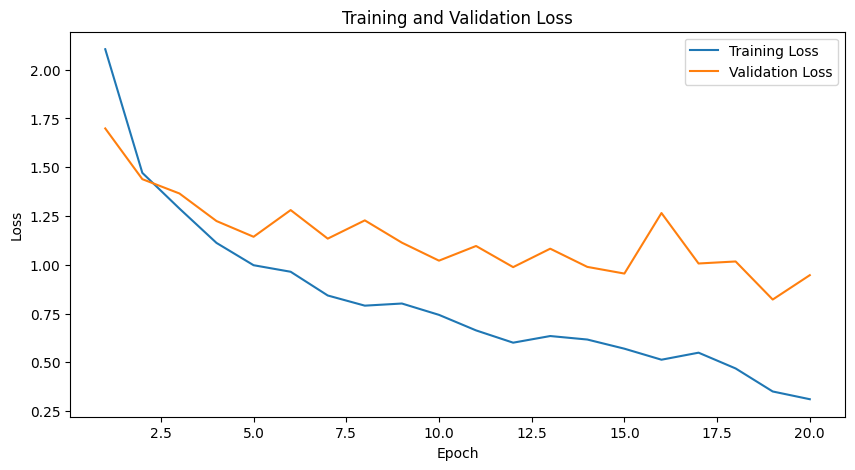

In [16]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_hist) + 1), train_loss_hist,label="Training Loss")
plt.plot(range(1, len(val_loss_hist) + 1), val_loss_hist,label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_curve_v5.png")
plt.show()


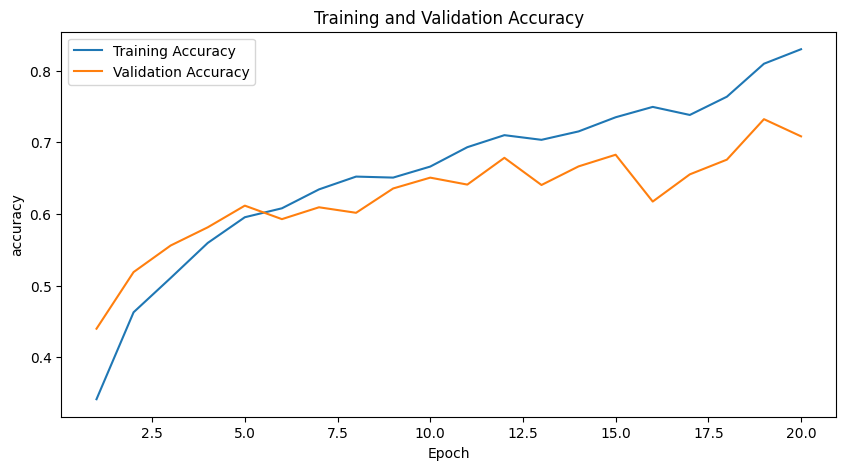

In [17]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_hist) + 1), train_acc_hist,label="Training Accuracy")
plt.plot(range(1, len(val_acc_hist) + 1), val_acc_hist,label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig("accuracy_curve_v5.png")
plt.show()

writer.close()

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

In [13]:
# Load best model weights
model.load_state_dict(torch.load("../model/dermai_model_v3.pth"))
model.eval()

y_true = []
y_pred = []
y_score = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # for ROC/AUC

In [18]:
# === Classification Report (Accuracy, Precision, Recall, F1) ===
import pandas as pd
from sklearn.metrics import classification_report

# Generate report as dict instead of string
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Round values for readability
report_df = report_df.round(4)

# Save as Markdown table
with open("classification_report.md", "w") as f:
    f.write(report_df.to_markdown())

# Also save as CSV (in case you want Excel/Word import)
report_df.to_csv("classification_report.csv", index=True)

print("✅ Classification report saved as 'classification_report.md' and 'classification_report.csv'")


✅ Classification report saved as 'classification_report.md' and 'classification_report.csv'


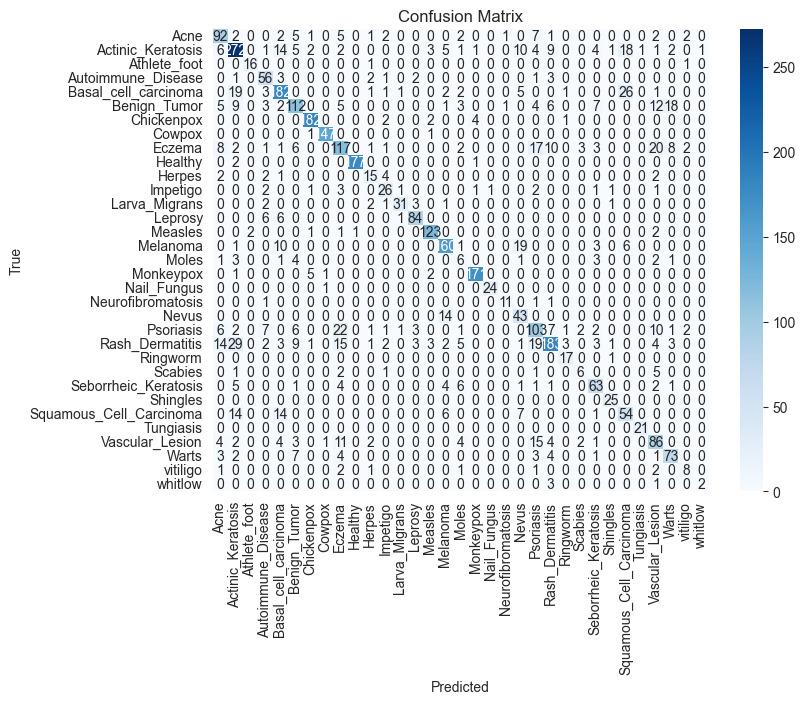

In [15]:
# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


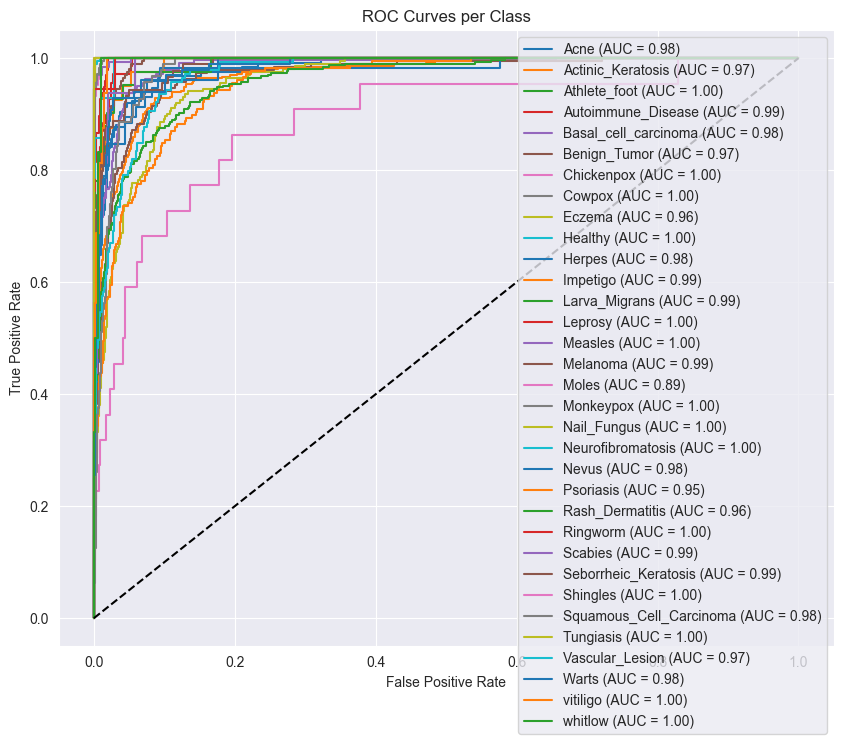

In [16]:
# === ROC / AUC per class ===
y_true_bin = np.eye(num_classes)[y_true]  # one-hot encode
fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_score)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend()
plt.savefig("roc_curves.png")
plt.show()